In [1]:
import pandas as pd
import numpy as np
import lib_tools as pt # Import Project Tools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import date

start_year = 2018
end_year = 2019

# load data into dictionnaries
dic_usagers = pt.load_usagers(start_year, end_year)
dic_caract  = pt.load_caract(start_year, end_year)
dic_vehic   = pt.load_vehicules(start_year, end_year)
dic_lieux   = pt.load_lieux(start_year, end_year)

### Preprocessings pour la construction de : df_usagers, df_caract, df_vehic, df_lieux

In [2]:
chk = False
df_usagers = pt.preproc_usagers(dic_usagers, chk)
df_caract = pt.preproc_caract(dic_caract, chk)
df_vehic = pt.preproc_vehic(dic_vehic, chk)
df_lieux = pt.preproc_lieux(dic_lieux, chk)

### Merge dans un seul DataFrame

In [3]:
df_all = pt.merge_dataframes(df_usagers=df_usagers, df_caract=df_caract, df_vehic=df_vehic, df_lieux=df_lieux)

### Transformation des  -1 (non renseigné) en *Null*

In [4]:
cols = ['atm', 'col', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 
        'senc', 'obs', 'obsm', 'choc', 'manv', 'motor', 'trajet', 'secu1', 'secu2', 
        'secu3', 'locp', 'actp', 'etatp', 'place', 'lum', 'int']

df_all[cols] = df_all[cols].replace(to_replace=[-1, '-1', ' -1'], value=np.nan)

### Représentation graphique des *Null*

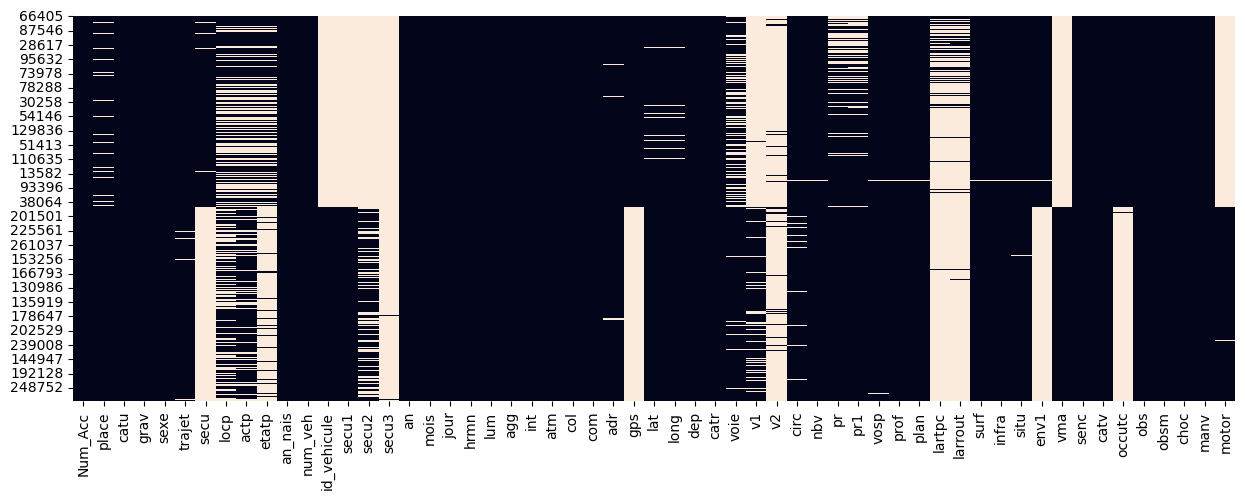

In [5]:
df_sample = df_all.sample(10000)
df_sample = df_sample.sort_values(by=['an', 'mois', 'jour'], ascending=True)

plt.figure(figsize=(15,5))
ax = sns.heatmap(df_sample.isna(), cbar=False);

### 1° suppression de variables

In [6]:
col_to_rmv = ['secu', 'secu1', 'secu2', 'secu3', 'id_vehicule', 'gps', 'pr', 'pr1', 'voie', 'v1', 'v2', 
               'lat', 'long', 'lartpc', 'larrout', 'env1', 'vma', 'occutc', 'motor', 'adr', 'locp', 'actp', 'etatp', 'com', 'dep']
print(f"{len(col_to_rmv)} colonnes à supprimer")

print(f"Dimensions du dataframe mergé avant suppression : {df_all.shape}")
df_all = df_all.drop(columns=col_to_rmv, axis=1)
print(f"Dimensions du dataframe mergé après suppression : {df_all.shape}")

25 colonnes à supprimer
Dimensions du dataframe mergé avant suppression : (262856, 57)
Dimensions du dataframe mergé après suppression : (262856, 32)


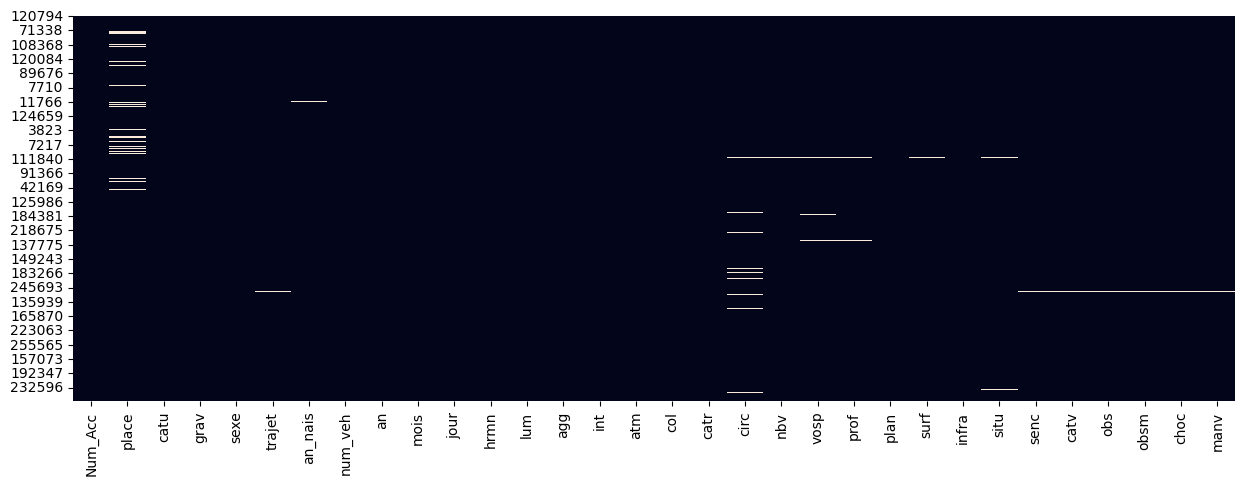

In [7]:
df_sample = df_all.sample(10000)
df_sample = df_sample.sort_values(by=['an', 'mois', 'jour'], ascending=True)

plt.figure(figsize=(15,5))
ax = sns.heatmap(df_sample.isna(), cbar=False);

### Remplacement des *Null* par les modalités les plus fréquentes

In [8]:
cols = df_all.columns[df_all.isnull().any()]

for col in cols:
    df_all = df_all.fillna(df_all[col].value_counts().index[0])

In [9]:
# Lignes contenant au moins une valeur manquante
# df_all[df_all.isna().any(axis = 1)]

### Création et catégorisation de la variable *age*  - suppression de *an_nais*

In [10]:
# Suppression des données aberrantes 
df_all['an_nais'].unique()

df_all = df_all.drop(df_all[df_all.an_nais == 1].index)

In [11]:
df_all = pt.create_col_age(df_all)
# df_all = df_all.drop(columns=['an_nais'], axis=1)

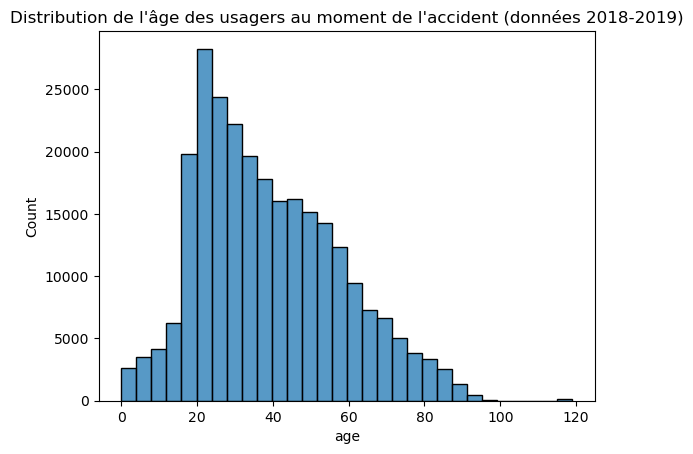

In [38]:
df_all.age.unique()
df_all[df_all['age'] > 120]

plt.title("Distribution de l'âge des usagers au moment de l'accident (données 2018-2019)")
# sns.histplot(data=df_all, x="age", hue="grav", multiple="stack", bins=30)
sns.histplot(data=df_all, x="age", bins=30);

In [36]:
df_all.age.describe()

count    262826.000000
mean         38.810441
std          19.006366
min           0.000000
25%          24.000000
50%          36.000000
75%          52.000000
max         119.000000
Name: age, dtype: float64

### Création de la variable joursem : jour de la semaine - suppression de 'an', 'mois', 'jour'

In [13]:
# renommage de ['an', 'mois', 'jour'] en ['year', 'month', day]
dic = {'an':'year', 'mois':'month', 'jour':'day'}
df_all = df_all.rename(dic, axis=1)

df_all["date"] = pd.to_datetime(df_all[['year', 'month', 'day']], errors = 'coerce')
df_all = df_all.drop(columns=['year', 'month', 'day'], axis=1)

In [14]:
import datetime

df_all['joursem'] = df_all["date"].dt.dayofweek
df_all['joursem'] = df_all['joursem'].replace([0, 1, 2, 3, 4, 5, 6], 
                                              ['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche'])

In [35]:
# for col in df_all.columns:
#     print(f"{col} : {len(df_all[col].unique())}")

# df_all[df_all.Num_Acc.isna()]

### Volume des données

In [16]:
# nb de lignes et colonnes de chaque DataFrame

dic = {'caract' : dic_caract, 'lieux' : dic_lieux, 'usagers': dic_usagers, 'vehic' : dic_vehic}

for key in dic.keys() : 
    print(f"\n{key} : \n")
    nb_lin = []
    nb_col = []
   
    for year in range(start_year, end_year+1):
        dic_data = dic[key]
        df = dic_data[year]
        nb_lin.append(df.shape[0])
        nb_col.append(df.shape[1])
        print(f'{key} {year} : {df.shape[1]} colonnes x {df.shape[0]} lignes')

    print(f"\nnombre de lignes min : {min(nb_lin)}")    
    print(f"\nnombre de lignes max : {max(nb_lin)}")    


caract : 

caract 2018 : 16 colonnes x 57783 lignes
caract 2019 : 15 colonnes x 58840 lignes

nombre de lignes min : 57783

nombre de lignes max : 58840

lieux : 

lieux 2018 : 18 colonnes x 57783 lignes
lieux 2019 : 18 colonnes x 58840 lignes

nombre de lignes min : 57783

nombre de lignes max : 58840

usagers : 

usagers 2018 : 12 colonnes x 130169 lignes
usagers 2019 : 15 colonnes x 132977 lignes

nombre de lignes min : 130169

nombre de lignes max : 132977

vehic : 

vehic 2018 : 9 colonnes x 98876 lignes
vehic 2019 : 11 colonnes x 100710 lignes

nombre de lignes min : 98876

nombre de lignes max : 100710


### Analyse intercorrelations between variables

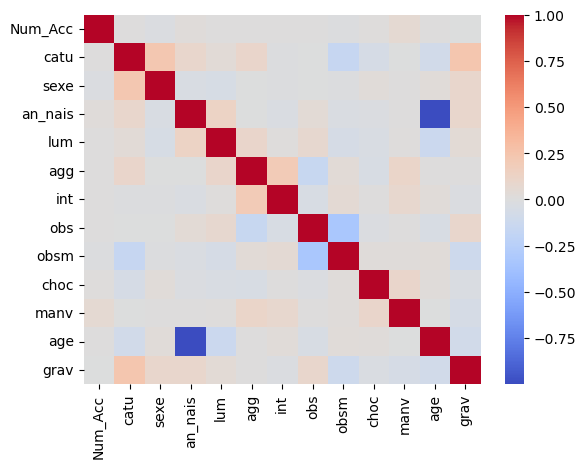

In [17]:
target = df_all['grav']
data = df_all.drop(columns=['grav'], axis=1)
# set 'grav' as last column of data
data['grav'] = target

# data = data.fillna(data.median())
# data_clean = data.dropna(how='any')

data_sample = data.sample(10000)
corr = data_sample.corr()

sns.heatmap(corr, annot=False, cmap='coolwarm');
# sns.clustermap(corr, annot=False, cmap='coolwarm');

### Evolution de gravité 'Blessé hospitalisé' en 2019?

In [18]:
df_usagers_2018 = df_all[df_all.an == 2018]
df_usagers_2019 = df_all[df_all.an == 2019]

# sns.histplot(df_usagers_2018.grav)
# ax = plt.hist([df_usagers_2018.grav, df_usagers_2019.grav], color=['r', 'b'], alpha=0.5)

print("\nDistribution de la variable gravité en 2018 : \n")
print(df_usagers_2018.grav.value_counts(normalize=True))

print("\nDistribution de la variable gravité en 2019 : \n")
print(df_usagers_2019.grav.value_counts(normalize=True))

AttributeError: 'DataFrame' object has no attribute 'an'